In [94]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [95]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [96]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
# cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [98]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [149]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    
    pseudo_count=1
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_IMC.merge(df_intensity_TS, on="Id")
    df.set_index("Id", inplace=True)
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adatas.append(adata)

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_4


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished (0:00:00)
DonorA_6 cannot be read


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/2502281287.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


In [150]:
IMC_markers = df_intensity_IMC.columns[1:]
SIMS_masses = df_intensity_TS.columns[1:]

In [151]:
# for adata in adatas:
#     adata_SIMS = adata[:, SIMS_masses]
#     df_SIMS = pd.DataFrame(adata_SIMS.X, columns=adata_SIMS.var_names)
#     g = sns.clustermap(df_SIMS,
#                    cmap='coolwarm', 
#                    row_cluster=True,
#                    col_cluster=True,
#                    cbar_pos=(.0, .32, .02, .2), 
#                    dendrogram_ratio=(.05, .05), 
#                    figsize=(25, 20), 
#                    yticklabels=False, 
#                    xticklabels=True,
#                    vmin=-2,
#                    vmax=2)
#     g.ax_row_dendrogram.set_visible(False)
#     plt.show()
#     break

# Combined

In [152]:
adata = ad.concat(adatas)
adata_SIMS = adata[:, SIMS_masses]
adata_SIMS.obs['Dataset'] = adata_SIMS.obs['Dataset'].astype("category")

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\AppData\Local\Temp/ipykernel_15388/3965904537.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Dataset'] = adata_SIMS.obs['Dataset'].astype("category")


In [153]:
adata_SIMS

AnnData object with n_obs × n_vars = 30767 × 189
    obs: 'Cell', 'Dataset', 'Core'
    obsm: 'spatial'

In [154]:
from kh import sketch
kh_indices, adata_subsample = sketch(adata_SIMS, sample_set_key = 'Dataset', gamma = 1, num_subsamples = 200, n_jobs = -1)

performing subsampling: 100%|██████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.53it/s]


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


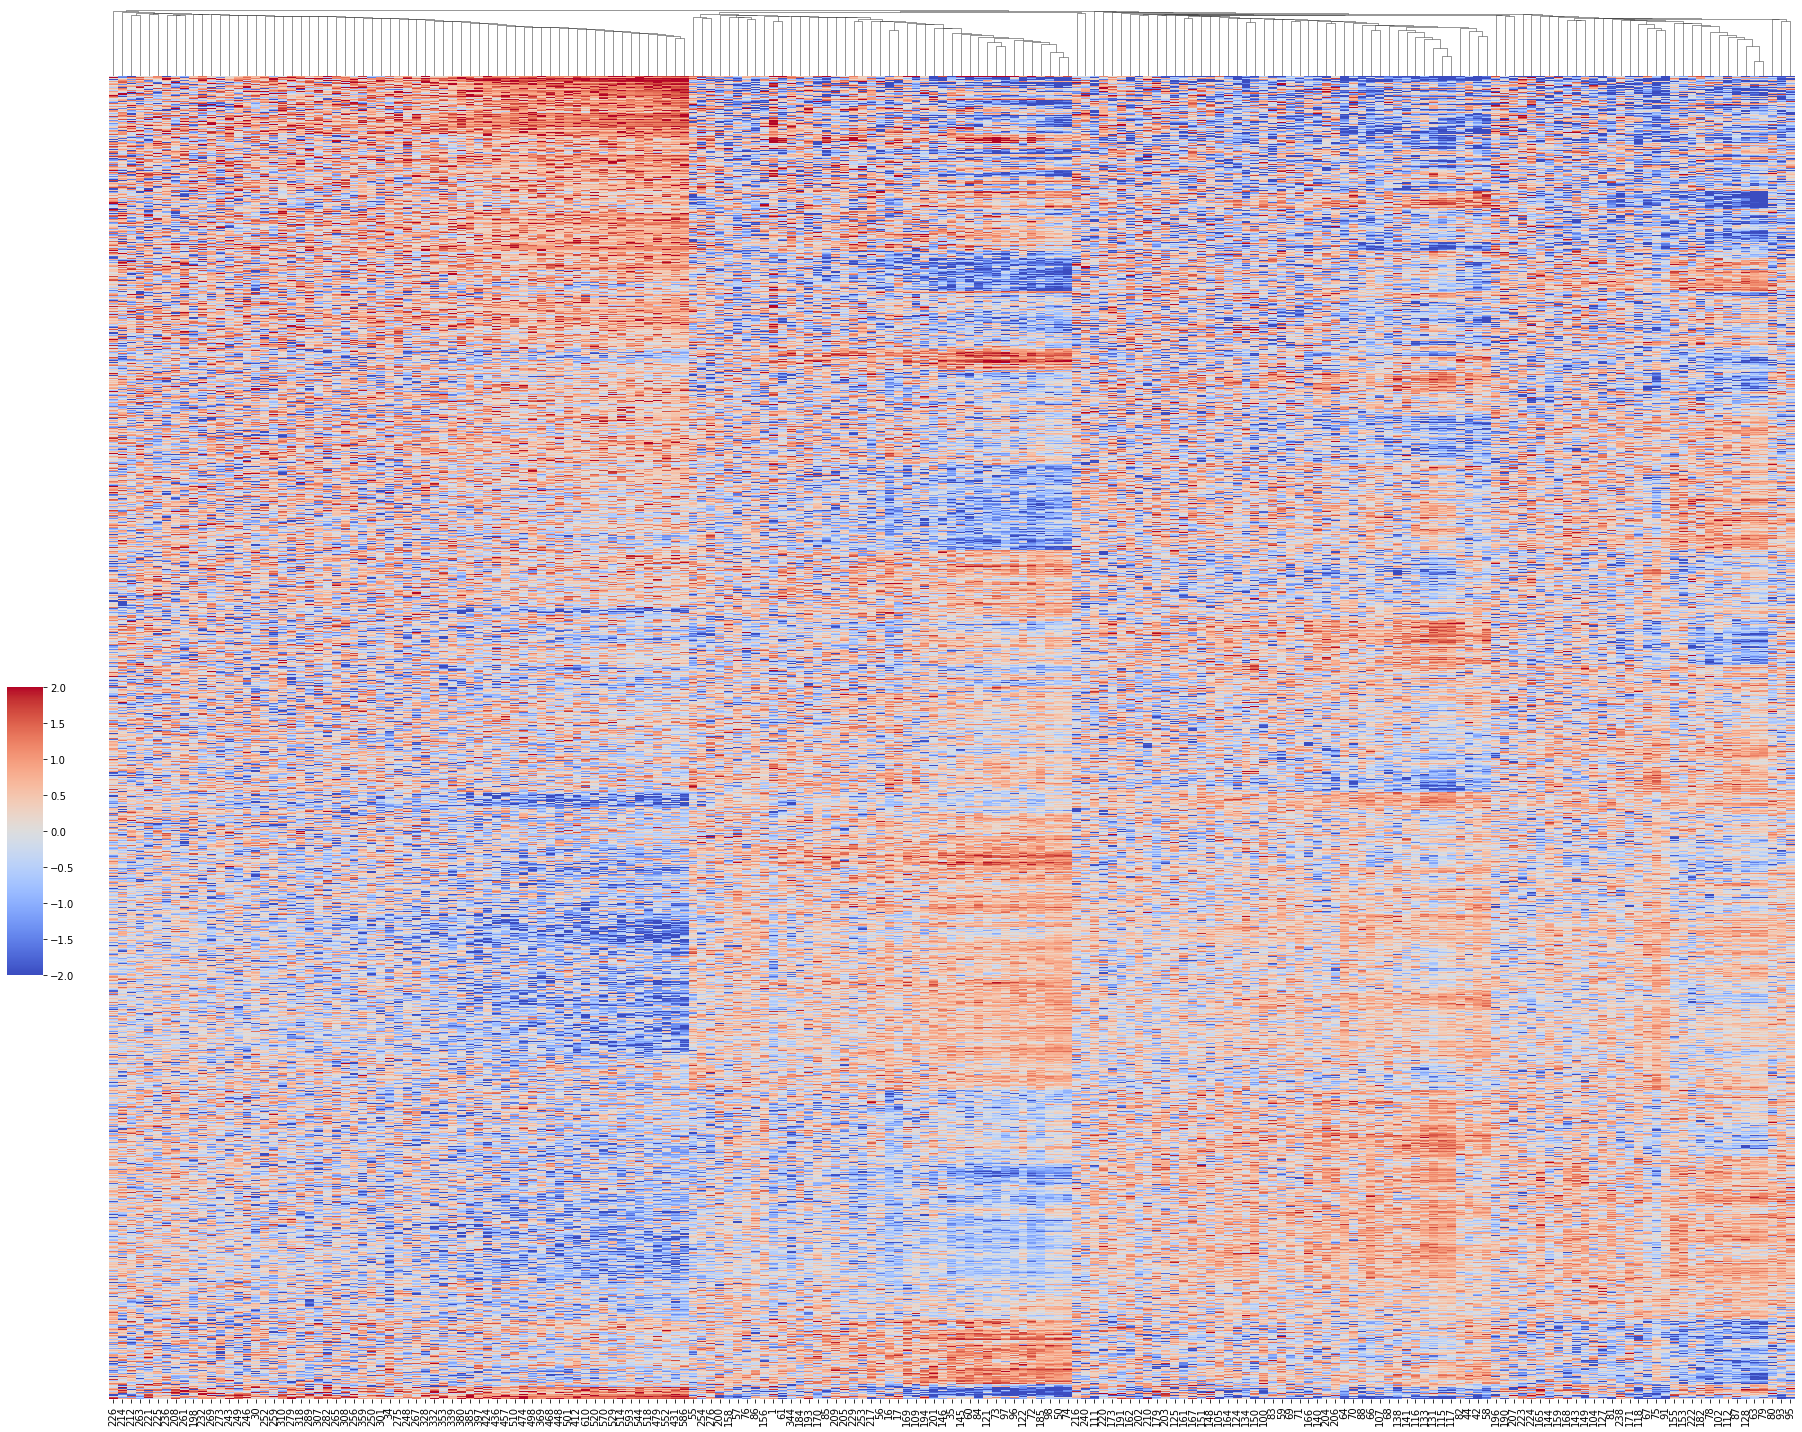

In [155]:
df_SIMS = pd.DataFrame(adata_subsample.X, columns=adata_subsample.var_names)
g = sns.clustermap(df_SIMS,
               cmap='coolwarm', 
               row_cluster=True,
               col_cluster=True,
               cbar_pos=(.0, .32, .02, .2), 
               dendrogram_ratio=(.05, .05), 
               figsize=(25, 20), 
               yticklabels=False, 
               xticklabels=True,
               vmin=-2,
               vmax=2)
g.ax_row_dendrogram.set_visible(False)

# Show images

In [133]:
from typing import List
import matplotlib
import skimage
from skimage import measure

h5_data_dir = p_dir / "data" / "h5"

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, cell2count,  **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]))

    for cell, counts in tqdm(cell2count.items(), total=len(cell2count)):
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = counts

    return img

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mz_img, cmap='rainbow', interpolation='quadric', vmin=0, vmax=np.percentile(mz_img, 90))  
    ax.axis('off')
    plt.title(f'{mz} m/z')
    plt.show()
    return mz_img 

In [134]:
masses = [
    50,
    190,
    191,
    193,
    194,
    196,
    198,
    200,
    201,
    202,
    203,
    55,
    204,
    205,
    206,
    207,
    208,
    209,
    210,
    212,
    214,
    216,
    56,
    217,
    220,
    221,
    222,
    223,
    224,
    225,
    226,
    229,
    232,
    57,
    236,
    238,
    240,
    243,
    246,
    248,
    249,
    250,
    252,
    253,
    58,
    254,
    256,
    259,
    261,
    263,
    265,
    267,
    269,
    273,
    275,
    59,
    276,
    279,
    282,
    289,
    301,
    307,
    308,
    310,
    318,
    60,
    328,
    332,
    339,
    344,
    353,
    359,
    369,
    380,
    385,
    397,
    61,
    412,
    424,
    431,
    436,
    448,
    457,
    468,
    474,
    479,
    498,
    63,
    501,
    510,
    514,
    518,
    520,
    529,
    544,
    552,
    570,
    586,
    64,
    593,
    610,
    1,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    16,
    76,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    17,
    87,
    88,
    91,
    93,
    95,
    96,
    97,
    98,
    100,
    102,
    30,
    104,
    105,
    107,
    109,
    111,
    112,
    115,
    116,
    117,
    118,
    34,
    121,
    122,
    124,
    125,
    127,
    128,
    131,
    133,
    134,
    138,
    35,
    140,
    141,
    143,
    144,
    145,
    146,
    148,
    149,
    150,
    151,
    42,
    153,
    155,
    156,
    158,
    159,
    161,
    162,
    164,
    165,
    166,
    44,
    167,
    168,
    169,
    170,
    171,
    173,
    179,
    182,
    184,
    185,
]
masses.sort()

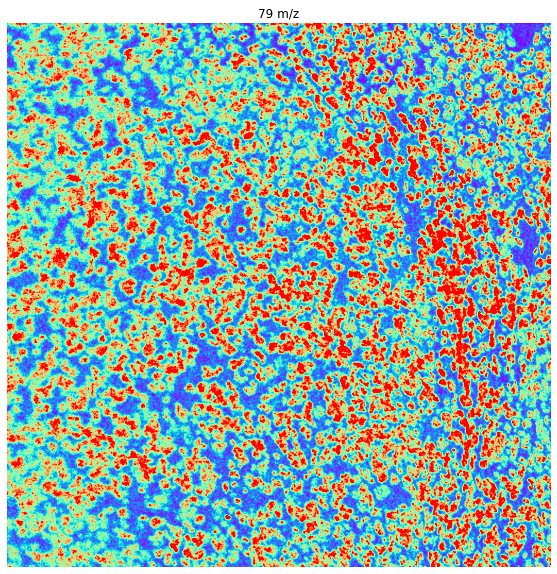

In [91]:
dataset = datasets[0]
channel = 79

# --- Read tof-sims images
imgs, labels = get_imgs_sims(experiment, dataset)
mz_img = IMS(imgs, channel, masses)

In [92]:
masks = get_masks(data_dir / "masks")
experiment='tonsil'

In [82]:
adata_subset = adata[adata.obs.Dataset == dataset, str(channel)]
mask = masks[experiment + '_' + dataset]
contours = get_contour(mask)

# Get label2cell dict
cells = adata_subset.obs['Cell'].to_list()
counts = adata_subset.X.flatten()
cell2count = dict(zip(cells, counts))

img = create_clustered_cell(mask, cell2count)


  0%|          | 0/2711 [00:00<?, ?it/s]

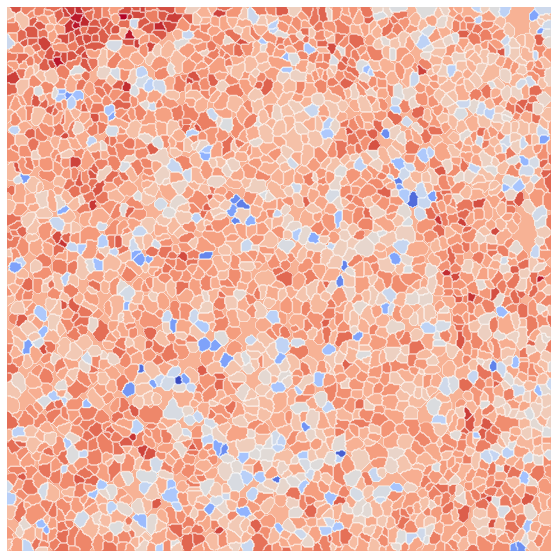

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='coolwarm')
for j, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
ax.axis("off")
plt.show()